In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import itertools
import random

from warnings import filterwarnings
filterwarnings('ignore')

Note that the '.txt' files are stored in CSV format.

In [ ]:
col_names = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])


train = pd.read_csv('/content/KDDTrain+.txt', header=None,names=col_names)
test = pd.read_csv('/content/KDDTest+.txt', header=None,names=col_names)


In [ ]:
#create new col attack_flg
train['attack_flg'] = train.attack.map(lambda a:0 if a=='normal' else 1)
test['attack_flg'] = test.attack.map(lambda a:0 if a=='normal' else 1)

In [ ]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flg
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0


In [ ]:
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
privilege_attacks = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
access_attacks = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']

attack_lbls = ['Normal','DoS','Probe','Privilege','Access']

def map_attack(attk):
  if attk in dos_attacks:
    atk_type=1
  elif attk in probe_attacks:
    atk_type=2
  elif attk in privilege_attacks:
    atk_type=3
  elif attk in access_attacks:
    atk_type=4
  else:
    atk_type=0
  return atk_type

attack_map = train.attack.apply(map_attack)  #applies map_attack func on attack col of train
train['attack_map'] = attack_map

attack_map_test = test.attack.apply(map_attack) #applies map_attack func on attack col of test
test['attack_map'] = attack_map_test

train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flg,attack_map
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0,0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,1,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0,0


# Data Profiling

In [ ]:
#get relationship bw attack and protocols to evaluate data
atk_prot = pd.crosstab(train.attack, train.protocol_type)
atk_prot

protocol_type,icmp,tcp,udp
attack,,,
back,0,956,0
buffer_overflow,0,30,0
ftp_write,0,8,0
guess_passwd,0,53,0
imap,0,11,0
ipsweep,3117,482,0
land,0,18,0
loadmodule,0,9,0
multihop,0,7,0


A description of each feature and a breakdown of the data set can be seen in the google spreadsheet [here](https://docs.google.com/spreadsheets/d/1oAx320Vo9Z6HrBrL6BcfLH6sh2zIk9EKCv2OlaMGmwY/edit#gid=0).

## Data Cleaning and Visualization


In [ ]:
#create target column
train['target'] = train.attack.apply(lambda x:0 if x=='normal' else 1)  #if attack is normal 0 else 1
test['target'] = test.attack.apply(lambda x:0 if x=='normal' else 1)
data = train['target'].value_counts()
data

,count
target,
0,67343
1,58630


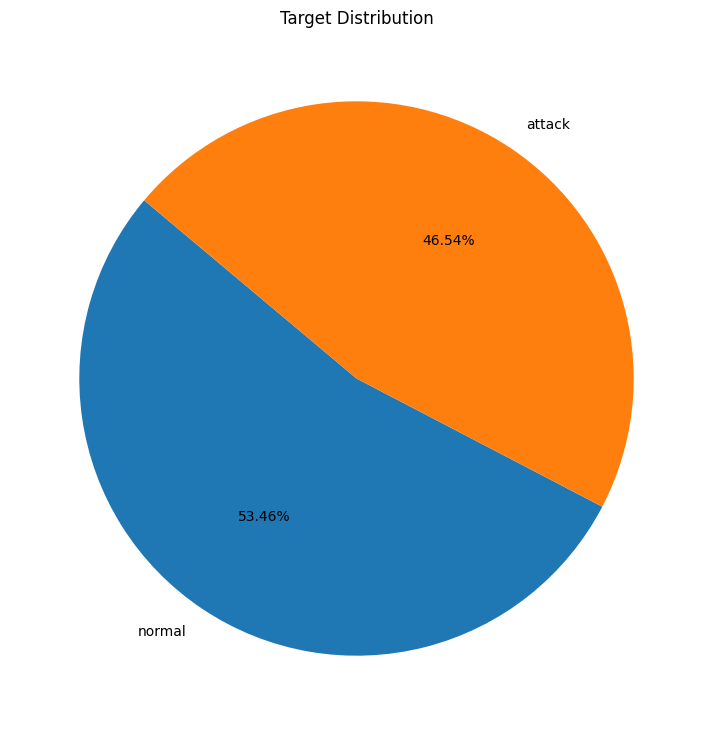

In [ ]:
plt.figure(figsize=(9,9))
plt.pie(data, labels=['normal', 'attack'], autopct='%2.2f%%',startangle=140)
plt.title('Target Distribution')
plt.show()

In [ ]:
train.drop(train.iloc[:, 41:45], inplace = True, axis = 1)
test.drop(test.iloc[:, 41:45], inplace = True, axis = 1)
train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,1
125969,8,udp,private,SF,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,0
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1


In [ ]:
cat = [1,2,3]

enc = LabelEncoder()
for col in cat:
    train.iloc[:,col] = pd.Series(enc.fit_transform(train.iloc[:,col]))
    test.iloc[:,col] = pd.Series(enc.transform(test.iloc[:,col]))


In [ ]:
# Selecting features and target variable
X = train.drop(columns=['target'])
y = train['target']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

The following are the models which will be trained and compared for the intrusion detection problem statement.
  * Decision Tree
  * Random Forest classifier
  * Support Vector Machines
  * Logistic Regression
  * Gaussian Naive Bayes
  * Multi-Layer Perceptron classifier
  


##Decision Tree


In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=7)

clf = clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)

print("Train score: ",clf.score(X_train, y_train))

pred_dt = clf.predict(X_test)
print('Test score:',clf.score(X_test, y_test))

print("Classification report: ",classification_report(pred_dt,y_test))

print("Average weighted precision: ",precision_score(y_test,pred_dt))
print("Average weighted recall: ",recall_score(y_test,pred_dt))
print("Average weighted f1 score: ",f1_score(y_test,pred_dt))

Train score:  0.9948174776879373
Test score: 0.9938875952582558
Classification report:                precision    recall  f1-score   support

           0       0.99      0.99      0.99     20108
           1       0.99      0.99      0.99     17684

    accuracy                           0.99     37792
   macro avg       0.99      0.99      0.99     37792
weighted avg       0.99      0.99      0.99     37792

Average weighted precision:  0.9941755258991178
Average weighted recall:  0.9927720368174374
Average weighted f1 score:  0.9934732856779589


## Random Forest


In [ ]:
rf_mod = RandomForestClassifier(n_estimators=200, criterion='entropy', random_state= 10, verbose= 1)
rf_mod.fit(X_train, y_train)

print("Train score: ",rf_mod.score(X_train, y_train))

pred_rf = rf_mod.predict(X_test)
print('Test score:',rf_mod.score(X_test, y_test))

print("Classification report: ",classification_report(pred_rf,y_test))

print("Average weighted precision: ",precision_score(y_test,pred_rf))
print("Average weighted recall: ",recall_score(y_test,pred_rf))
print("Average weighted f1 score: ",f1_score(y_test,pred_rf))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Train score:  0.9999773193771901


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Test score: 0.9987828111769687
Classification report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00     20107
           1       1.00      1.00      1.00     17685

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792

Average weighted precision:  0.9993780039581567
Average weighted recall:  0.9980236038172681
Average weighted f1 score:  0.9987003446911906


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


## Support Vector Machine


In [ ]:
svm_mod = SVC(probability=True)
svm_mod.fit(X_train, y_train)

print("Train score: ",svm_mod.score(X_train, y_train))

pred_svc = svm_mod.predict(X_test)
print('Test score:',svm_mod.score(X_test, y_test))

print("Classification report: ",classification_report(pred_svc,y_test))

print("Average weighted precision: ",precision_score(y_test,pred_svc))
print("Average weighted recall: ",recall_score(y_test,pred_svc))
print("Average weighted f1 score: ",f1_score(y_test,pred_svc))

Train score:  0.9924586929157074
Test score: 0.9910298475867908
Classification report:                precision    recall  f1-score   support

           0       0.99      0.99      0.99     20112
           1       0.99      0.99      0.99     17680

    accuracy                           0.99     37792
   macro avg       0.99      0.99      0.99     37792
weighted avg       0.99      0.99      0.99     37792

Average weighted precision:  0.9912330316742082
Average weighted recall:  0.9896098029250664
Average weighted f1 score:  0.990420752211139


## Gaussian Naive Bayes


In [ ]:
gnb_mod = GaussianNB()
gnb_mod.fit(X_train, y_train)

print("Train score: ",gnb_mod.score(X_train, y_train))

pred_nb = gnb_mod.predict(X_test)
print('Test score:',gnb_mod.score(X_test, y_test))

print("Classification report: ",classification_report(pred_nb,y_test))

print("Average weighted precision: ",precision_score(y_test,pred_nb))
print("Average weighted recall: ",recall_score(y_test,pred_nb))
print("Average weighted f1 score: ",f1_score(y_test,pred_nb))

Train score:  0.8759143126070242
Test score: 0.8746295512277731
Classification report:                precision    recall  f1-score   support

           0       0.81      0.94      0.87     17317
           1       0.94      0.82      0.88     20475

    accuracy                           0.87     37792
   macro avg       0.88      0.88      0.87     37792
weighted avg       0.88      0.87      0.87     37792

Average weighted precision:  0.8167521367521368
Average weighted recall:  0.9443220961093229
Average weighted f1 score:  0.8759166142887073


## Logistic Regression

In [ ]:
lg_mod = LogisticRegression()
lg_mod.fit(X_train, y_train)

print("Train score: ",lg_mod.score(X_train, y_train))

pred_lg = lg_mod.predict(X_test)
print('Test score:',lg_mod.score(X_test, y_test))

print("Classification report: ",classification_report(pred_lg,y_test))

print("Average weighted precision: ",precision_score(y_test,pred_lg))
print("Average weighted recall: ",recall_score(y_test,pred_lg))
print("Average weighted f1 score: ",f1_score(y_test,pred_lg))

Train score:  0.955171749016228
Test score: 0.9534557578323455
Classification report:                precision    recall  f1-score   support

           0       0.96      0.95      0.96     20386
           1       0.94      0.96      0.95     17406

    accuracy                           0.95     37792
   macro avg       0.95      0.95      0.95     37792
weighted avg       0.95      0.95      0.95     37792

Average weighted precision:  0.9581753418361485
Average weighted recall:  0.9417810153029533
Average weighted f1 score:  0.9499074469599886


## Multi-Layer Perceptron


In [ ]:
mlp_mod = MLPClassifier(hidden_layer_sizes=[100,50])
mlp_mod.fit(X_train, y_train)

print("Train score: ",mlp_mod.score(X_train, y_train))

pred_mlp = mlp_mod.predict(X_test)
print('Test score:',mlp_mod.score(X_test, y_test))

print("Classification report: ",classification_report(pred_mlp,y_test))

print("Average weighted precision: ",precision_score(y_test,pred_mlp))
print("Average weighted recall: ",recall_score(y_test,pred_mlp))
print("Average weighted f1 score: ",f1_score(y_test,pred_mlp))

Train score:  0.9980721470611583
Test score: 0.9966924216765453
Classification report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00     20068
           1       1.00      1.00      1.00     17724

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792

Average weighted precision:  0.9960505529225908
Average weighted recall:  0.9968942345699927
Average weighted f1 score:  0.9964722151666525


## Model Comparision


No Skill AUC:  0.5
DecisionTree AUC:  0.9970058555936901


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s


RandomForest AUC:  0.9999930015434535
Support Vector Machine AUC:  0.9989727649172868
Logistic Regression AUC:  0.9912766333904819
Gaussian Naive Bayes AUC:  0.9400337138342703
MultiLayer Perceptron AUC:  0.9995934231345247


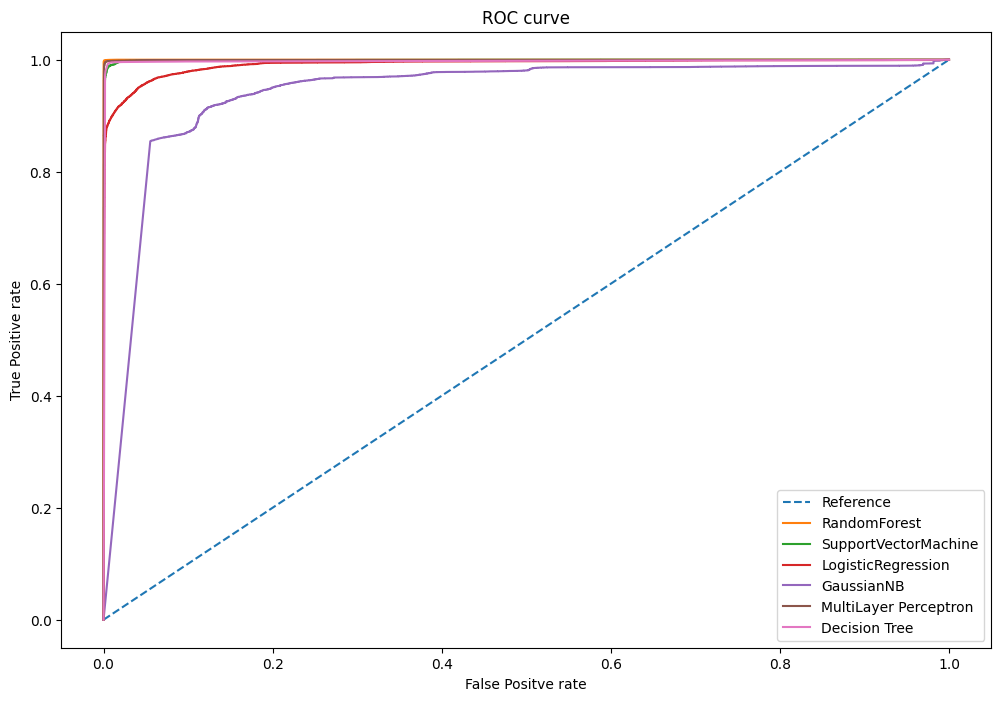

In [ ]:
no_skill_prob = [0 for _ in range(len(y_test))]
no_skill_auc = roc_auc_score(y_test, no_skill_prob)
print("No Skill AUC: ", no_skill_auc)
ns_fpr, ns_tpr, _ = roc_curve(y_test, no_skill_prob)

dt_prob = clf.predict_proba(X_test)[:,-1]
dt_auc = roc_auc_score(y_test,dt_prob)
print("DecisionTree AUC: ", dt_auc)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_prob)

rf_prob = rf_mod.predict_proba(X_test)[:,-1]
rf_auc = roc_auc_score(y_test,rf_prob)
print("RandomForest AUC: ", rf_auc)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)

svm_prob = svm_mod.predict_proba(X_test)[:,-1]
svm_auc = roc_auc_score(y_test,svm_prob)
print("Support Vector Machine AUC: ", svm_auc)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_prob)

lg_prob = lg_mod.predict_proba(X_test)[:,-1]
lg_auc = roc_auc_score(y_test, lg_prob)
print("Logistic Regression AUC: ",lg_auc)
lg_fpr, lg_tpr, _ = roc_curve(y_test, lg_prob)

nb_prob = gnb_mod.predict_proba(X_test)[:,-1]
nb_auc = roc_auc_score(y_test, nb_prob)
print("Gaussian Naive Bayes AUC: ", nb_auc)
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_prob)


mlp_prob = mlp_mod.predict_proba(X_test)[:,-1]
mlp_auc = roc_auc_score(y_test, mlp_prob)
print("MultiLayer Perceptron AUC: ", mlp_auc)
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, mlp_prob)

fig,ax = plt.subplots(figsize=(12,8))
ax.plot(ns_fpr, ns_tpr, linestyle= '--', label= 'Reference')
ax.plot(rf_fpr, rf_tpr, linestyle= '-', label= 'RandomForest')
ax.plot(svm_fpr, svm_tpr, linestyle= '-', label= 'SupportVectorMachine')
ax.plot(lg_fpr, lg_tpr, linestyle='-', label= 'LogisticRegression')
ax.plot(nb_fpr, nb_tpr, linestyle='-', label= 'GaussianNB')
ax.plot(mlp_fpr, mlp_tpr, linestyle='-', label= 'MultiLayer Perceptron')
ax.plot(dt_fpr, dt_tpr, linestyle='-', label= 'Decision Tree')
plt.xlabel('False Positve rate')
plt.ylabel('True Positive rate')
plt.title('ROC curve')
ax.legend(loc="lower right")

The below plot is a zoomed in version of the ROC curve plot, to clearly distinguish between the models.

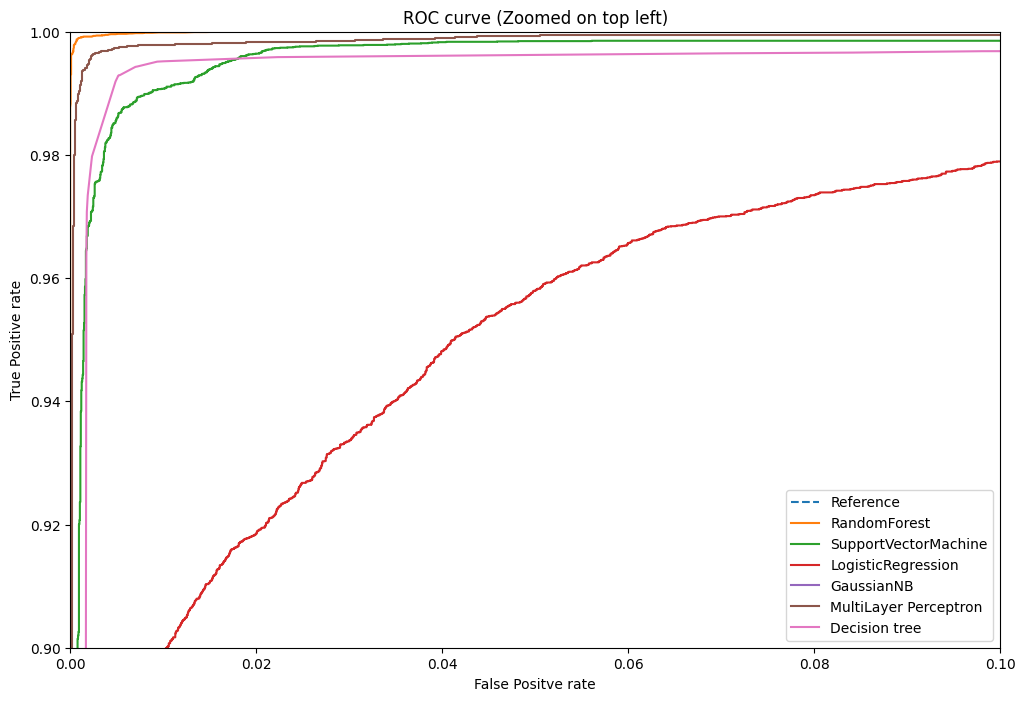

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(ns_fpr, ns_tpr, linestyle= '--', label= 'Reference')
ax.plot(rf_fpr, rf_tpr, linestyle= '-', label= 'RandomForest')
ax.plot(svm_fpr, svm_tpr, linestyle= '-', label= 'SupportVectorMachine')
ax.plot(lg_fpr, lg_tpr, linestyle='-', label= 'LogisticRegression')
ax.plot(nb_fpr, nb_tpr, linestyle='-', label= 'GaussianNB')
ax.plot(mlp_fpr, mlp_tpr, linestyle='-', label= 'MultiLayer Perceptron')
ax.plot(dt_fpr, dt_tpr, linestyle='-', label= 'Decision tree')
plt.xlabel('False Positve rate')
plt.ylabel('True Positive rate')
plt.title('ROC curve (Zoomed on top left)')
plt.xlim([0,0.1])
plt.ylim([0.9,1])
ax.legend(loc="lower right")

### Reliability Curve

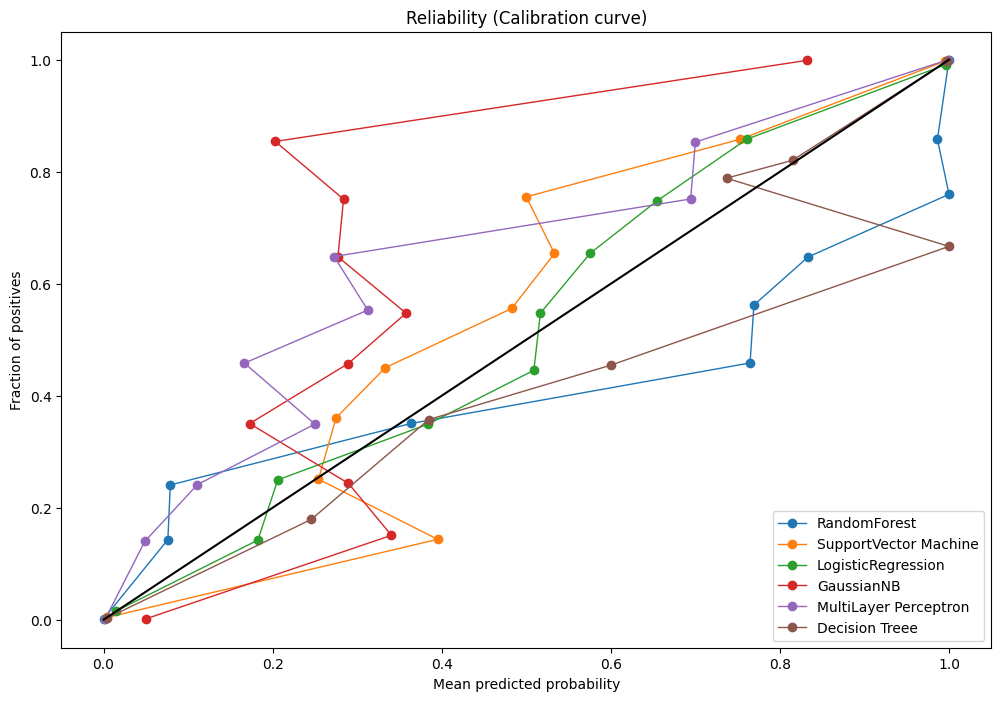

In [ ]:
rf_x, rf_y = calibration_curve(y_test, rf_prob, n_bins=10)
sv_x, sv_y = calibration_curve(y_test, svm_prob, n_bins=10)
lg_x, lg_y = calibration_curve(y_test, lg_prob, n_bins=10)
nb_x, nb_y = calibration_curve(y_test, nb_prob, n_bins=10)
mlp_x, mlp_y = calibration_curve(y_test, mlp_prob, n_bins=10)
dt_x, dt_y = calibration_curve(y_test,dt_prob,n_bins=10)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(rf_x, rf_y, marker= 'o', linewidth= '1', label= 'RandomForest')
ax.plot(sv_x, sv_y, marker= 'o', linewidth= '1', label= 'SupportVector Machine')
ax.plot(lg_x, lg_y, marker= 'o', linewidth= '1', label= 'LogisticRegression')
ax.plot(nb_x, nb_y, marker= 'o', linewidth= '1', label= 'GaussianNB')
ax.plot(mlp_x, mlp_y, marker= 'o', linewidth= '1', label= 'MultiLayer Perceptron')
ax.plot(dt_x, dt_y, marker= 'o', linewidth= '1', label= 'Decision Treee')

line = mlines.Line2D([0,1],[0,1], color='black')
ax.add_line(line)
ax.legend()
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability (Calibration curve)')
plt.show()

The table below tabulates all the scores from each model for a clear comparision.

In [ ]:
models = {
    'Random Forest':rf_mod,
    'Support Vector Machine': svm_mod,
    'Logistic Regression':lg_mod,
    'Gaussian Naive Bayes': gnb_mod,
    'Multi-Layer Perceptron':mlp_mod,
    'Decision tree':clf
}

columns = [
    'accuracy',
    'precision',
    'recall',
    'f1'
]

table = {}


for model in models.keys():

    pred = models[model].predict(X_test)
    accuracy = models[model].score(X_test,y_test)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test,pred)

    table[model] = [accuracy, precision, recall, f1]

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s


In [ ]:
results = pd.DataFrame.from_dict(table, orient='index')
results.columns = columns
results

,accuracy,precision,recall,f1
Random Forest,0.998783,0.999378,0.998024,0.998700
Support Vector Machine,0.991030,0.991233,0.989610,0.990421
Logistic Regression,0.953456,0.958175,0.941781,0.949907
Gaussian Naive Bayes,0.874630,0.816752,0.944322,0.875917
Multi-Layer Perceptron,0.996692,0.996051,0.996894,0.996472
Decision tree,0.993888,0.994176,0.992772,0.993473


In [ ]:
dataset_size=len(test)
print(dataset_size)

22544


In [ ]:
dataset_size=len(train)
print(dataset_size)

125973


#Model Enhancement
XGBoost is chosen because it handles large datasets and complex relationships well.
Hyperparameter tuning optimizes the number of trees, learning rate, and other parameters for better performance.

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')   #XGBoost is an ensemble learning method that combines the predictions of multiple weak models to produce a strong prediction

#hyperparam grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [3, 6, 10],        # Depth of each tree
    'learning_rate': [0.01, 0.1, 0.2],  # Step size
    'subsample': [0.6, 0.8, 1.0]    # Fraction of samples used for training
}

# hyperparam tuning using RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=10,
    scoring='f1_macro',
    cv=3,
    random_state=42,
    verbose=1
)

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters and F1 score
print("Best Parameters:", random_search.best_params_)
print("Best F1 Score from CV:", random_search.best_score_)

# Evaluate the best model on the test data
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.2}
Best F1 Score from CV: 0.9987916021302922
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     20083
           1       1.00      1.00      1.00     17709

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792



#Data Handling
We’ll address:

1. Class imbalance using SMOTE (Synthetic Minority Oversampling Technique).
2. Use k-fold cross-validation for a more robust evaluation.

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from collections import Counter

# Step 1: Handling class imbalance with SMOTE
print("Before SMOTE:", Counter(y_train))
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print("After SMOTE:", Counter(y_train_balanced))

# Step 2: K-fold cross-validation
scores = cross_val_score(best_model, X, y, cv=5, scoring='f1_macro')
print("Cross-Validation F1 Scores:", scores)
print("Mean F1 Score:", scores.mean())

Before SMOTE: Counter({0: 47260, 1: 40921})
After SMOTE: Counter({0: 47260, 1: 47260})
Cross-Validation F1 Scores: [0.99888327 0.99944165 0.99884339 0.9992422  0.99932198]
Mean F1 Score: 0.9991464986309033


# Deployment
Build a pipeline for preprocessing and prediction.
Create a Flask REST API for deployment.

In [ ]:
#pipeline code
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Step 1: Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('classifier', RandomForestClassifier(random_state=42))
])

# Step 2: Fit the pipeline
pipeline.fit(X_train, y_train)

# Step 3: Make predictions
y_pred_pipeline = pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_pipeline))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     20083
           1       1.00      1.00      1.00     17709

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792



In [ ]:
#flask Rest API Code
from flask import Flask, request, jsonify
import joblib

# Save the trained model pipeline
joblib.dump(pipeline, 'intrusion_model_pipeline.pkl')

# Load the model in the Flask app
app = Flask(__name__)
model = joblib.load('intrusion_model_pipeline.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    # Get JSON input
    data = request.get_json()
    # Make prediction
    prediction = model.predict([data['features']])
    return jsonify({'prediction': int(prediction[0])})

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
